<a href="https://colab.research.google.com/github/smomtahe/Logistic_Regression/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of MNIST digits with dense layers

## Loading the image data

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import gzip
import math
import operator
import sklearn.model_selection
import random
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as matplot
import matplotlib
%matplotlib inline
import pandas as pd
import numpy as np
import pickle as cPickle
import seaborn as sb

from time import time
from itertools import chain
from subprocess import check_output
from collections import Counter
from PIL import Image
from math import ceil
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from pandas.plotting import parallel_coordinates

from scipy import optimize as op
mnist = tf.keras.datasets.mnist

train_data, test_data = mnist.load_data()

train_images_original, train_labels_original = train_data
test_images_original, test_labels_original = test_data

11493376/11490434 [==============================] - 0s 0us/step


## Preparing the image data

In [ ]:
train_images = train_images_original.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images_original.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255



## Preparing the labels

We need to categorically encode the labels.

In [ ]:
train_labels = train_labels_original
test_labels = test_labels_original

## Deplaying some of the original and prepared image data and labels

In [ ]:
train_images_original.shape

(60000, 28, 28)

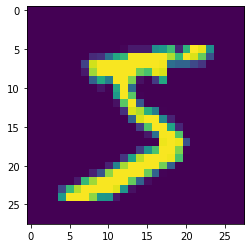

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_images_original[0])
plt.show()

In [ ]:
train_labels.shape

(60000,)

In [ ]:
train_labels[0]

5

In [ ]:
import numpy as np

In [ ]:
np.argmax(train_labels[0])

0

In [ ]:
train_labels_original[0]

5

In [ ]:
train =train_images
trlab =train_labels
test=test_images
tslab =test_labels
train.shape

(60000, 784)

In [ ]:
# for example , 3 and 6 are chosen
dx1=3
dx2=6
def filter(x, y):
      for i in range (len(x)):
        keep = (y == dx1) | (y ==dx2)
        y =  y[keep]
        x =  x[np.where(keep)[i]]
        #y = y == dx1
        return x,y.astype(int)
train, trlab = filter(train,trlab)
test, tslab = filter(test,tslab)

#Number of examples
m = train.shape[0]
#Features
n = train.shape[1]
#Number of classes
k=2
lab = [dx1,dx2]
intercept = np.ones((train.shape[0], 1))
X = np.hstack((intercept, train))
intercept = np.ones((test.shape[0], 1))
test = np.hstack((intercept, test))
print(X.shape)
trlab[:10]
#train[:1]


(12049, 785)


array([3, 3, 3, 6, 6, 3, 3, 6, 6, 6])

In [ ]:
def error_rate(confusion_matrix):
    a = confusion_matrix
    b = a.sum(axis=1)
    df = []
    for i in range(0,2):
        temp = 1-a[i][i]/b[i]
        df.append(temp)

    df = pd.DataFrame(df)
    df.columns = ['% Error rate']
    return df*100

In [ ]:
def sigmoid(z):
  #print (z)
  for i in range(len(z)):
      if (z[i]>=0): #Optimize the sigmoid function to avoid extreme data overflow
          h=(1.0 / (1 + np.exp(-z)))
          #print(h)
          return 1.0 / (1 + np.exp(-z))
      else:
          #print(np.exp(z)/(1+np.exp(z)))
          return np.exp(z)/(1+np.exp(z))

  #return 1.0 / (1 + np.exp(-z))

#Regularized cost function
def regCostFunction(theta, X, y, L = 0.1, batch_size= 1000000): # L is the lambda
    #print(y) # y axtual 0:7,1:3   ok

    theta = theta.reshape(-1, 1)
    m, n = X.shape
    theta = theta.reshape((n, 1))
    error_list = []
    #max_iters = 100
    #for itr in range(max_iters):
    mini_batches = create_mini_batches(X, y, batch_size)
    #print(y) #ok
    #for mini_batch in mini_batches:
    #X_mini, y_mini = mini_batch
    #print( X_mini.shape) #307 proob
    #print(h)
    #print(y_mini) # 1,0 actual label  #303

    y = y.reshape((m, 1))
    h = sigmoid(X.dot(theta))  #hypothesis
    #print(h) #ok
    tmp = np.copy(theta)
    reg = (L/(2*m)) * np.sum(tmp**2)
    #print((1 / m) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h))) + reg)  #print cost
    return (1 / m) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h))) + reg

#Regularized gradient function
def regGradient(theta, X, y, L = 0.1, batch_size= 1000000):
    #print(y[:3]) # actual 0 ,1
    m, n = X.shape
    theta=(np.ones((n ,1)) * -1)
    #print(theta.shape)
    theta = theta.reshape(-1, 1)
    theta = theta.reshape((n, 1))
    #y = trlab.reshape((m, 1))
    y=y.reshape(m,1)  # actual 0 ,1
    h = sigmoid(X.dot(theta))   # 1.4*10^-9,...
    #print(h) #ok
    tmp = np.copy(theta)
    tmp[0] = 0
    reg = L*tmp/m
    alpha=0.1
    #print(((alpha / m) * X.T.dot(h - y)) + reg  )  #print theta
    return ((alpha / m) * X.T.dot(h - y)) + reg

#Optimal theta
def logisticRegression(X, y, theta, batch_size):

    #print(y) # y actual label, 1: 3, 0: 7
    result = op.minimize(regCostFunction, theta, (X, y), method = 'TNC', jac = regGradient, options={'maxiter': 10000})
    # options={'gtol': 1e-3, 'disp': True, 'maxiter': 1000}
    return result.x

# function to create a list containing mini-batches
def create_mini_batches(X, y, batch_size):
    #print(y) #actual 0,1
    mini_batches = []
    #3 vs 7
    temp=[dx1]  # first digit
    #set the labels in -1 and 1
    tmp_y = np.array(trlab == temp, dtype = int)
    #print(tmp_y)   #y actual 0,1
    #print(X.shape)
    #print(y.shape)
    y1=tmp_y.reshape(tmp_y.shape[0], 1)
    data = np.hstack((X, y1))
    #print(X.shape) #307
    #np.random.shuffle(data)
    n_minibatches = data.shape[0] // batch_size
    i = 0
    for i in range(n_minibatches + 1):
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
        X_mini = mini_batch[:, :-1]
        #print(X_mini.shape)
        Y_mini = mini_batch[:, -1]
        #print(Y_mini)
        mini_batches.append((X_mini, Y_mini))
    if data.shape[0] % batch_size != 0:
        mini_batch = data[i * batch_size:data.shape[0]]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    #print(Y_mini) # 0,1 actual
    return mini_batches

#Training

all_theta = np.zeros((k, n + 1))
temp=[dx1]
#set the labels in -1 and 1
tmp_y = np.array(trlab == temp, dtype = int)
#print(tmp_y)   #y actual 0,1
optTheta = logisticRegression(X, tmp_y, (np.ones((n + 1,1)) * -1),batch_size = 1000000)
all_theta = optTheta
#print(all_theta)  #all theta

###############################################################
# example of grid searching key hyperparametres for ridge classifier
# to find best L reguarization
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# define dataset
(12049, 785)
'''
X, y = make_blobs(n_samples=1000, centers=2, n_features=785, cluster_std=20)
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
L = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=L)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### to find best alpha
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
# define dataset
X, y = make_blobs(n_samples=1000, centers=2, n_features=785, cluster_std=20)
# define models and parameters
model = RidgeClassifier()
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# define grid search
grid = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    '''

'\nX, y = make_blobs(n_samples=1000, centers=2, n_features=785, cluster_std=20)\n# define models and parameters\nmodel = LogisticRegression()\nsolvers = [\'newton-cg\', \'lbfgs\', \'liblinear\']\npenalty = [\'l2\']\nL = [100, 10, 1.0, 0.1, 0.01]\n# define grid search\ngrid = dict(solver=solvers,penalty=penalty,C=L)\ncv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)\ngrid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=\'accuracy\',error_score=0)\ngrid_result = grid_search.fit(X, y)\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n\n### to find best alpha\nfrom sklearn.datasets import make_blobs\nfrom sklearn.model_selection

In [ ]:
'''
maxiter= 10000
alpha=0.1
L = [10, 1.0, 0.1, ]
acc = [67,67.47,81.55,80.487,70.376,53.5,51.32]

matplot.subplots(figsize=(10, 5))
matplot.semilogx(L, acc,'-gD' , label="Accuracy")
#matplot.xticks(L,L)
matplot.grid(True)
matplot.xlabel("Lambda")
matplot.ylabel("Test Accuracy")
matplot.legend()
matplot.title('Test accuracy versus the regularization value(log-scale)')
matplot.show()
'''

'\nmaxiter= 10000\nalpha=0.1\nL = [10, 1.0, 0.1, ]\nacc = [67,67.47,81.55,80.487,70.376,53.5,51.32]\n\nmatplot.subplots(figsize=(10, 5))\nmatplot.semilogx(L, acc,\'-gD\' , label="Accuracy")\n#matplot.xticks(L,L)\nmatplot.grid(True)\nmatplot.xlabel("Lambda")\nmatplot.ylabel("Test Accuracy")\nmatplot.legend()\nmatplot.title(\'Test accuracy versus the regularization value(log-scale)\')\nmatplot.show()\n'

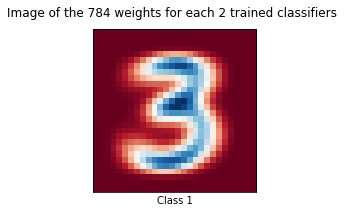

In [ ]:
matplot.subplots(1,1, figsize=(3,3))
for i in range(1):
    l1 = matplot.subplot(1, 1, i + 1)
    l1.imshow(all_theta[1:785].reshape(28, 28),cmap=matplot.cm.RdBu)

    l1.set_xticks(())
    l1.set_yticks(())
    l1.set_xlabel('Class %i' % 1)
matplot.suptitle('Image of the 784 weights for each 2 trained classifiers')
matplot.show()

Test Accuracy: 87.8048780487805 %


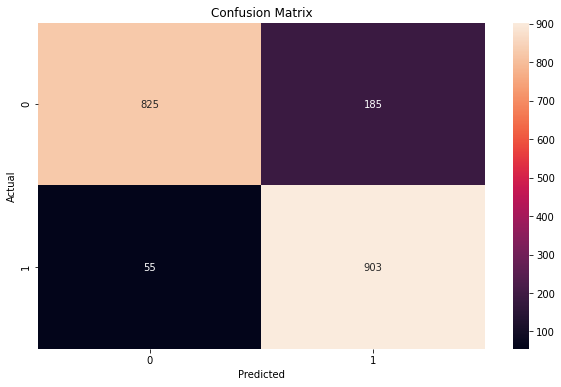

Precision: 0.885
Recall (sensitivity): 0.878
Specificity: 0.817
F1_score: 0.878


,% Error rate
0,18.316832
1,5.741127


In [ ]:
#prediction
#compute accuracy  #####test
P = sigmoid(test.dot(all_theta)) #probability for each temp
#print(all_theta.shape) # all weights
#print(P.shape) #hypothesis
probabilities = []
accuratepredicts = 0

for i in range (len(P)):
  if (P[i]>=0.5):
    hypothesis=dx1
  else:
    hypothesis=dx2
  probabilities.append(hypothesis)
  #print(probabilities)

  if (tslab.T[i] == probabilities[i]):
    accuratepredicts+=1
#print(accuratepredicts)

acc=(accuratepredicts/len(P))*100  #accuracy
print("Test Accuracy:", acc , '%')

# X-axis Predicted vs Y-axis Actual Values
matplot.subplots(figsize=(10, 6))
sb.heatmap(confusion_matrix(tslab, probabilities), annot = True, fmt = 'g')
matplot.xlabel("Predicted")
matplot.ylabel("Actual")
matplot.title("Confusion Matrix")
matplot.show()

from sklearn.metrics import precision_score
from sklearn import metrics
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

precision = precision_score(tslab, probabilities, average='weighted')
recall_sensitivity = metrics.recall_score(tslab, probabilities,average='weighted')
f1_positive = metrics.f1_score(tslab, probabilities,average='weighted')
specificity = metrics.recall_score(tslab, probabilities, pos_label=dx1)
print('Precision: %.3f' % precision)
print('Recall (sensitivity): %.3f' % recall_sensitivity)
print('Specificity: %.3f' % specificity)
print('F1_score: %.3f' % f1_positive)
error_rate(confusion_matrix(tslab, probabilities))


Train Accuracy: 84.97800647356627 %


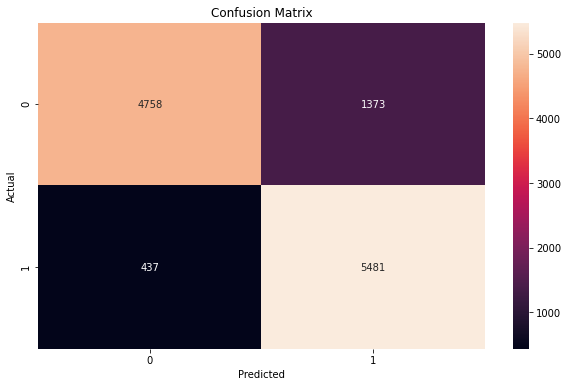

Precision: 0.859
Recall (sensitivity): 0.850
Specificity: 0.776
F1_score: 0.849


,% Error rate
0,22.394389
1,7.384251


In [ ]:
#prediction
#compute accuracy
P = sigmoid(X.dot(all_theta)) #probability for each temp
#print(all_theta.shape) # all weights
#print(P.shape) #hypothesis
probabilities = []
accuratepredicts = 0

for i in range (len(P)):
  if (P[i]>=0.5):
    hypothesis=dx1
  else:
    hypothesis=dx2
  probabilities.append(hypothesis)
  #print(probabilities)

  if (trlab.T[i] == probabilities[i]):
    accuratepredicts+=1
#print(accuratepredicts)

acc=(accuratepredicts/len(P))*100  #accuracy
print("Train Accuracy:", acc , '%')

# X-axis Predicted vs Y-axis Actual Values
matplot.subplots(figsize=(10, 6))
sb.heatmap(confusion_matrix(trlab, probabilities), annot = True, fmt = 'g')
matplot.xlabel("Predicted")
matplot.ylabel("Actual")
matplot.title("Confusion Matrix")
matplot.show()


from sklearn.metrics import precision_score
from sklearn import metrics
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

precision = precision_score(trlab, probabilities, average='weighted')
recall_sensitivity = metrics.recall_score(trlab, probabilities,average='weighted')
f1_positive = metrics.f1_score(trlab, probabilities,average='weighted')
specificity = metrics.recall_score(trlab, probabilities, pos_label=dx1)
print('Precision: %.3f' % precision)
print('Recall (sensitivity): %.3f' % recall_sensitivity)
print('Specificity: %.3f' % specificity)
print('F1_score: %.3f' % f1_positive)

### error
error_rate(confusion_matrix(trlab, probabilities))

In [ ]:
'''
train_score = []
test_score = []
k_vals = []
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
for k in range(1, len(trlab)):
    k_vals.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X, trlab)

    tr_score = knn.score(X, trlab)
    train_score.append(tr_score)

    te_score = knn.score(test, tslab)
    test_score.append(te_score)

plt.figure(figsize=(10,5))
plt.xlabel('Different Values of K')
plt.ylabel('Model score')
plt.plot(k_vals, train_score, color = 'r', label = "training score")
plt.plot(k_vals, test_score, color = 'b', label = 'test score')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.show()

knn = KNeighborsClassifier(n_neighbors = 14)
#Fit the model
knn.fit(X,trlab)
#get the score
knn.score(test,tslab)
'''

'\ntrain_score = []\ntest_score = []\nk_vals = []\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.neighbors import KNeighborsRegressor\nfor k in range(1, len(trlab)):\n    k_vals.append(k)\n    knn = KNeighborsClassifier(n_neighbors = k)\n    knn.fit(X, trlab)\n    \n    tr_score = knn.score(X, trlab)\n    train_score.append(tr_score)\n    \n    te_score = knn.score(test, tslab)\n    test_score.append(te_score)\n\nplt.figure(figsize=(10,5))\nplt.xlabel(\'Different Values of K\')\nplt.ylabel(\'Model score\')\nplt.plot(k_vals, train_score, color = \'r\', label = "training score")\nplt.plot(k_vals, test_score, color = \'b\', label = \'test score\')\nplt.legend(bbox_to_anchor=(1, 1),\n           bbox_transform=plt.gcf().transFigure)\nplt.show()\n\nknn = KNeighborsClassifier(n_neighbors = 14)\n#Fit the model\nknn.fit(X,trlab)\n#get the score\nknn.score(test,tslab)\n'